<a href="https://colab.research.google.com/github/isaacwanderers/artcreate/blob/main/CLIP_GLaSS_New_function_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP-GLaSS

Wellcome to the Google's Colab demo of CLIP-GLaSS.

For faster results we encourage you to use your own GPU.


## Instructions

1) Click the play button of the first block titled "CLIP-GLaSS initialization" and wait for it to finish the initialization

2) Select a config and a target from the form titled "CLIP-GLaSS settings"

3) Click the play button of the block titled "CLIP-GLaSS settings"

4) Output Images or Textfile is saved in /content/result/ folder in your files option on the left side bar.

##Notes

Final Development of Jupyter Notebook New Interface. The script allows user to choose between 3 development modes:

1) Make the machine interpret a Gund Gallery Artwork to Text

2) Make a random artwork from any description

3) Choose an artwork in the Gund Gallery collection, describe an element in the artwork that stood out, and create a new artwork that is related to the original artwork but has the element emphasized. 

Before asking you to choose the images in development mode 1 and 3, it should display the images in the genre you choose in the console. You must type in the full file name with the .jpg extension to proceed with the run. There should be try - except an other error-catching conditionals built in the script to prevent wrong input type.

In [1]:
#@title CLIP-GLaSS initialization
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
        
with HiddenPrints():
    import subprocess
    import re

    nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
    version = re.findall("release (\d+\.\d+)", nvcc)[0]

    pytorch_suffix = {
        "10.0": "+cu100",
        "10.1": "+cu101",
        "10.2": "",
    }

    pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
    torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

    %cd /content
    !mkdir result
    !git clone https://github.com/isaacwanderers/artcreate.git
    %cd artcreate

    try:
      import torch
    except:
      !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

    try:
      import ipyplot
    except:
      !pip install ipyplot

    try:
      import torchvision
    except:
      !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

    try:
      import wget
    except:
      !pip install wget

!pip install pytorch_pretrained_biggan==0.1.1 pymoo==0.4.2.1 kornia==0.4.1 ftfy==5.8 tensorboard==2.4.1


import argparse
import os
import torch
import numpy as np
import pickle
import glob
import random
import array
import PIL.Image
import ipyplot
import matplotlib.pyplot as plt
import time
from os.path import exists
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
from IPython.display import Image, display
import torchvision
import urllib.request
import wget

from config import get_config
from problem import GenerationProblem
from operators import get_operators
import warnings
warnings.filterwarnings('ignore')

def display_genre_images(genre):
  image_files = sorted(glob.glob("/content/artcreate/gpt2_images/" + genre +"/*.jpg")) 
  all_images = []
  all_file_names = []

  for f in image_files:
    #enumerate() returns the index number/order number of the images and the root pathway of the image.
    try:
      image = PIL.Image.open(f)
      #open each image as an Image object class, which was imported above from the PIL module.
      all_images.append(image)
      all_file_names.append(f)
    except:
      print("error reading", f)

  file_name = [i.rpartition('/')[2] for i in all_file_names]
  ipyplot.plot_images(all_images, file_name, img_width=150)
  if len(file_name) <= 20:
    time.sleep(15)
  else:
    time.sleep(30)
  return file_name

import IPython
import uuid
from google.colab import output
from google.colab import files

class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

def download_file():
  files.download(result_path)
  print("File Successfully Downloaded!")



Input your target phrase: a red car
n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |      32 |  0.00000E+00 |  0.00000E+00 |      -0.2267 |      -0.1792
    2 |      64 |  0.00000E+00 |  0.00000E+00 |      -0.2284 |      -0.2031
    3 |      96 |  0.00000E+00 |  0.00000E+00 |      -0.2284 |      -0.2129
    4 |     128 |  0.00000E+00 |  0.00000E+00 |      -0.2491 |      -0.2188
    5 |     160 |  0.00000E+00 |  0.00000E+00 |      -0.2491 |      -0.2218
    6 |     192 |  0.00000E+00 |  0.00000E+00 |      -0.2542 |      -0.2247
    7 |     224 |  0.00000E+00 |  0.00000E+00 |      -0.2542 |      -0.2274
    8 |     256 |  0.00000E+00 |  0.00000E+00 |      -0.2542 |      -0.2296
    9 |     288 |  0.00000E+00 |  0.00000E+00 |      -0.2563 |       -0.232
   10 |     320 |  0.00000E+00 |  0.00000E+00 |      -0.2563 |      -0.2351
   11 |     352 |  0.00000E+00 |  0.00000E+00 |        -0.26 |      -0.2393
   12 |     384 |  0.00000E+00 |  0.00000E+00 |     

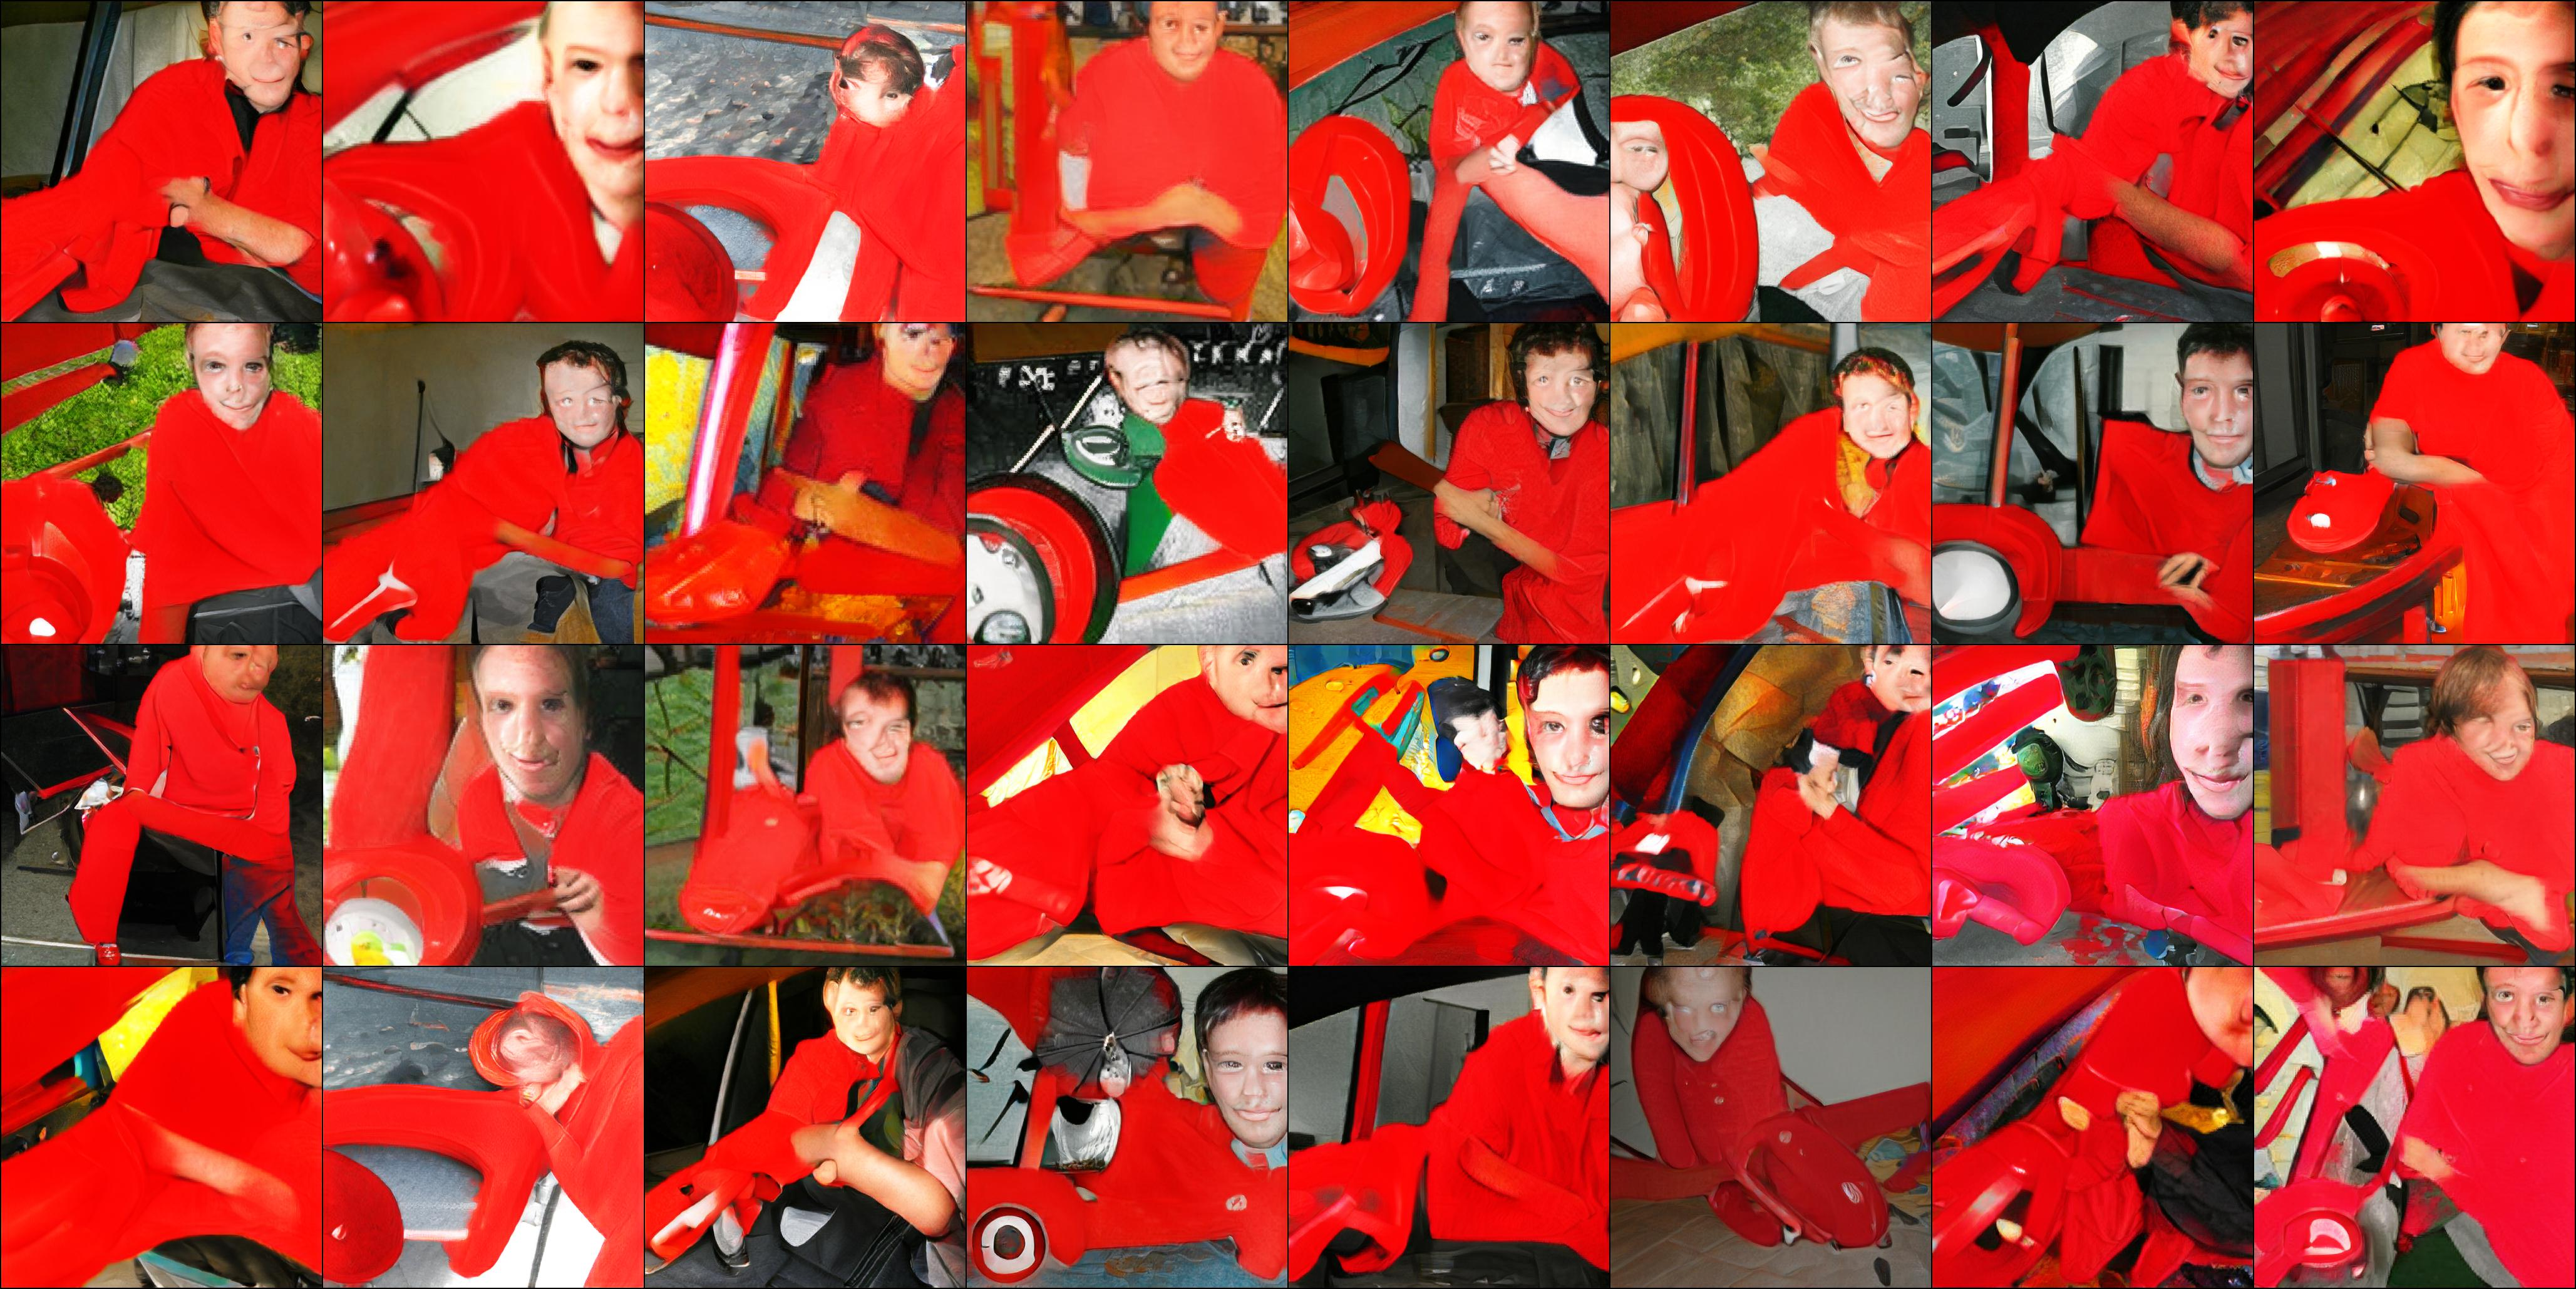

RESULT


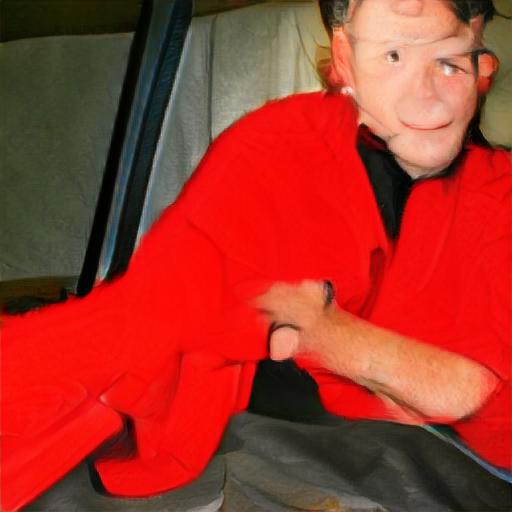

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File Successfully Downloaded!


In [3]:
#@title CLIP-GLaSS settings


development_mode = "create art from text" #@param ["interpret Gund Gallery art to text", "create art from text", "create new art from Gund Gallery art"]
genre = "Photograph" #@param ["Drawing", "Mixed Media Art", "Painting", "Photograph", "Print", "Sculpture"]
save_each =  100#@param {type:"number"}
generations = 100 #@param {type:"number"}
if development_mode == "interpret Gund Gallery art to text":
  file_exists = exists('/content/artcreate/gpt2/weights/gpt2-pytorch_model.bin')
  if not file_exists:
    print('Setting up image recognition system for the first time')
    ! chmod 755 ./download-weights.sh
    ! ./download-weights.sh GPT2
    print('Finish setting up image recognitiion system!')
  print("---All images available in genre---")
  file_name = display_genre_images(genre)
  target_image = input("Input the file name of the image you want to interpret: ")
  while target_image.rpartition('.')[2] != "jpg":
    print("File input error: Please include the file extension!")
    target_image = input("Re-input the file name of the image you want to interpret: ")
  while target_image not in file_name:
    print("File input error: Please type your file name correctly!")
    target_image = input("Re-input the file name of the image you want to interpret: ")
  target = "/content/artcreate/gpt2_images/" + genre + "/" + target_image
  print("---Chosen Image---")
  display(Image(target))
  print(target_image)
  config = "GPT2" 
elif development_mode == "create art from text":
  target = input("Input your target phrase: ") 
  config = "DeepMindBigGAN512"
  target = genre.lower() + " with " + target
else:
  file_exists = exists('/content/artcreate/gpt2/weights/gpt2-pytorch_model.bin')
  if not file_exists:
    print('Setting up image recognition system for the first time')
    ! chmod 755 ./download-weights.sh
    ! ./download-weights.sh GPT2
    print('Finish setting up image recognitiion system!')
  file_name = display_genre_images(genre)
  target_image = input("Input the file name of the image you want to develop: ")
  while target_image.rpartition('.')[2] != "jpg":
    print("File input error: Please include the file extension!")
    target_image = input("Re-input the file name of the image you want to develop: ")
  while target_image not in file_name:
    print("File input error: Please type your file name correctly!")
    target_image = input("Re-input the file name of the image you want to develop: ")
  target = "/content/artcreate/gpt2_images/" + genre + "/" + target_image
  print("---Chosen Image---")
  display(Image(target))
  print(target_image)
  element = input("What element stands out the most to you? (1-2 words) ")  
  config = "GPT2"
   

  config = argparse.Namespace(
      config=config,
      target=target,
      device="cuda",
      generations=generations,
      save_each=save_each,
      tmp_folder="./tmp"
  )

  vars(config).update(get_config(config.config))


  iteration = 0
  def save_callback(algorithm):
      global iteration
      global config

      iteration += 1
      if iteration % config.save_each == 0 or iteration == config.generations:
          if config.problem_args["n_obj"] == 1:
              sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
              X = np.stack([p.X for p in sortedpop])  
          else:
              X = algorithm.pop.get("X")
          
          ls = config.latent(config)
          ls.set_from_population(X)

          with torch.no_grad():
              generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
              name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

              if config.task == "txt2img":
                  algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                  display(Image(os.path.join(config.tmp_folder, name)))
              elif config.task == "img2txt":
                  print("\n".join(generated))
          

  problem = GenerationProblem(config)
  operators = get_operators(config)

  if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

  algorithm = get_algorithm(
      config.algorithm,
      pop_size=config.pop_size,
      sampling=operators["sampling"],
      crossover=operators["crossover"],
      mutation=operators["mutation"],
      eliminate_duplicates=True,
      callback=save_callback,
      **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=True,
  )


  pickle.dump(dict(
      X = res.X,
      F = res.F,
      G = res.G,
      CV = res.CV,
  ), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


  if config.problem_args["n_obj"] == 1:
      X = np.atleast_2d(res.X)
  else:
      try:
          result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
      except:
          print("Warning: cant use pseudo-weights")
          result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
      X = res.X[result]
      X = np.atleast_2d(X)


  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)

  problem.generator.save(generated, ("/content/result/output.txt"))
  text_file = open("/content/result/output.txt", "r")
  target = text_file.read()
  text_file.close()
  config = "DeepMindBigGAN512"
  target = genre.lower() + " with " + target.rpartition("of")[2]
  !rm /content/result/output.txt
  #End of the first text to image intepretation phase of the 3rd development mode.


config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))


iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])  
        else:
            X = algorithm.pop.get("X")
        
        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))
        

problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", int(config.generations)),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)

#Check to see if there are previous output files exist in the result directory.
#Previous outputs means that this is not the first instance of the program in this script.

output_names = sorted(glob.glob("/content/result/*"))
if len(output_names) ==0:
    n = 1
else:
    n = int(output_names[-1].rpartition('.')[0].rpartition('_')[2]) + 1

if config.task == "txt2img":
    result_path = "/content/result/output_" + str(n)+ ".jpg"
    problem.generator.save(generated, result_path)
    display(Image(result_path))

elif config.task == "img2txt":
    result_path = "/content/result/output_" + str(n)+ ".txt"
    print(generated)
    problem.generator.save(generated, result_path)

#This line is here because it cannot be put inside a loop
InvokeButton('Download Final Result', download_file) 